Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?

In [1]:
import numpy as np 
import pandas as pd 

%matplotlib inline
import matplotlib.pyplot as plt

from datetime import timedelta

In [2]:
drag = pd.read_csv('drag.csv', sep=';', index_col=[0], parse_dates=[0], dayfirst=True)

full_list_date = pd.date_range(drag.index.min(), drag.index.max(), freq="D")

colum_data = drag.columns

full_date = pd.DataFrame(full_list_date, index=full_list_date)

drag = drag.loc[drag.index < drag.index.max()]
drag = drag.loc[drag.index > drag.index.min()]

for col in colum_data:
    drag[col] = drag[col].str.replace(',','.',regex=True)
    drag[col] = drag[col].astype('float64')

diff_list_drag = set(full_list_date) - set(drag.index.unique())
print(f'Количество пропущенных дней: {len(diff_list_drag)}')

drag = full_date.merge(drag, how='left', left_index=True, right_index=True)
drag = drag.drop([0], axis=1)

one_day = timedelta(days=1)

for col in colum_data:
    mas = drag.loc[drag[col].isna(), [col]].index
    for i in mas:    
        min_day_value = None
        min_day = i
        while(True):
            min_day = min_day - one_day
            if min_day < drag.index.min():
                break;
            min_day_value = drag.loc[min_day, [col]].values[0]
            if min_day_value > 1:
                break;

        max_day_value = None
        max_day = i
        while(True):
            max_day = max_day + one_day
            if max_day > drag.index.max():
                break;
            max_day_value = drag.loc[max_day, [col]].values[0]
            if max_day_value > 1:
                break;

        if max_day_value and min_day_value:
            drag.loc[i, [col]] = (max_day_value + min_day_value) / 2
        elif max_day_value:
            drag.loc[i, [col]] = max_day_value
        elif min_day_value:
            drag.loc[i, [col]] = min_day_value    
        
drag.info()    
drag.head(5)
drag.tail(5)

Количество пропущенных дней: 1069
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3316 entries, 2010-08-03 to 2019-08-31
Freq: D
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Золото    3316 non-null   float64
 1   Серебро   3316 non-null   float64
 2   Платина   3316 non-null   float64
 3   Палладий  3316 non-null   float64
dtypes: float64(4)
memory usage: 289.5 KB


,Золото,Серебро,Платина,Палладий
2019-08-27,3189.70,36.16,1805.05,3096.80
2019-08-28,3263.35,37.76,1823.56,3148.63
2019-08-29,3291.97,39.21,1853.37,3155.85
2019-08-30,3297.60,39.66,1965.71,3186.76
2019-08-31,3297.60,39.66,1965.71,3186.76


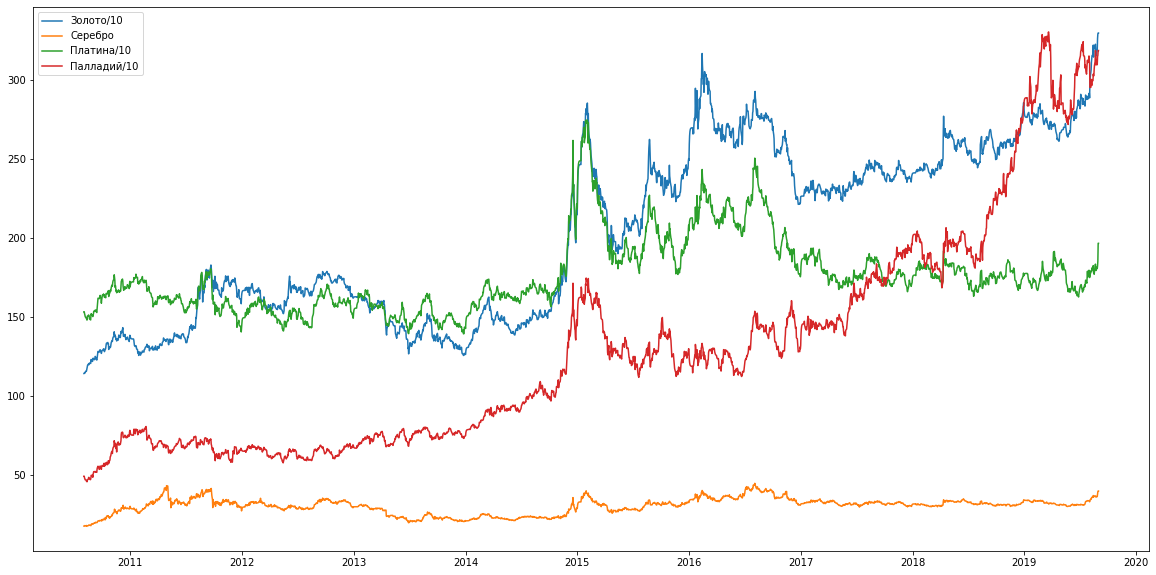

In [3]:
plt.figure(figsize =(20,10))
plt.plot(drag.index, drag['Золото']/10, label='Золото/10' )
plt.plot(drag.index, drag['Серебро'], label='Серебро' )
plt.plot(drag.index, drag['Платина']/10, label='Платина/10' )
plt.plot(drag.index, drag['Палладий']/10, label='Палладий/10' )
plt.legend()
plt.show()

In [7]:
drag_paladium = drag.copy()
drag_paladium = drag_paladium.drop(['Золото', 'Серебро', 'Платина'], axis=1)

In [49]:
drag_paladium['day'] = drag_paladium.index.day
drag_paladium['month'] = drag_paladium.index.month
drag_paladium['year'] = drag_paladium.index.year
drag_paladium['quarter'] = drag_paladium.index.quarter
drag_paladium['dayofyear'] = drag_paladium.index.dayofyear
drag_paladium['weekofyear'] = drag_paladium.index.weekofyear
drag_paladium['dayofweek'] = drag_paladium.index.dayofweek
drag_paladium.head()

,Палладий,day,month,year,quarter,dayofyear,weekofyear,dayofweek
2010-08-03,490.42,3,8,2010,3,215,31,1
2010-08-04,490.42,4,8,2010,3,216,31,2
2010-08-05,478.98,5,8,2010,3,217,31,3
2010-08-06,475.26,6,8,2010,3,218,31,4
2010-08-07,468.04,7,8,2010,3,219,31,5


In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [51]:
def split_data( data, split_date ):
    return data.loc[data.index <= split_date].copy(), \
           data.loc[data.index >  split_date].copy()

In [130]:
scl_x=StandardScaler() 

X = drag_paladium.iloc[:,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(3316, 8)

In [131]:
h=1

y = X[h:, 0].reshape((drag_paladium.shape[0]-h,1))
y.shape

(3315, 1)

In [132]:
X = X[:-h,:]
X.shape

(3315, 8)

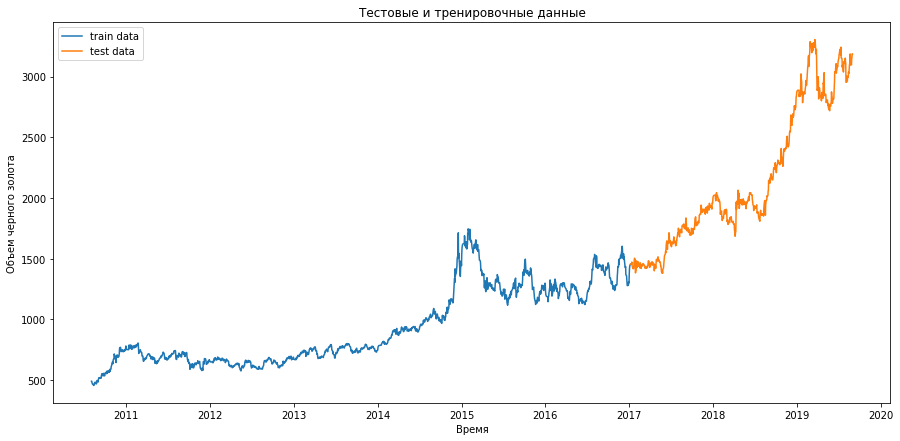

In [133]:
train, test = split_data( drag_paladium, '01-06-2017')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Объем черного золота')
plt.plot(train.index, train['Палладий'], label='train data' )
plt.plot(test.index, test['Палладий'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [134]:
X_train = X[:train.shape[0], :]
y_train = y[:train.shape[0], 0]
X_test = X[train.shape[0]:, :]
y_test = y[train.shape[0]:, 0]

In [152]:
# список признаков, по которым будем учить
channelIndexes = ['Палладий', 'day', 'month', 'year', 'quarter', 'dayofyear', 'weekofyear', 'dayofweek']

# длина истории для работы
xLen = 5

# параметры модели для обучения
learning_rate = 0.001
batch_size = 30
epochs = 10

In [153]:
train.head(7)

,Палладий,day,month,year,quarter,dayofyear,weekofyear,dayofweek
2010-08-03,490.42,3,8,2010,3,215,31,1
2010-08-04,490.42,4,8,2010,3,216,31,2
2010-08-05,478.98,5,8,2010,3,217,31,3
2010-08-06,475.26,6,8,2010,3,218,31,4
2010-08-07,468.04,7,8,2010,3,219,31,5
2010-08-08,467.46,8,8,2010,3,220,31,6
2010-08-09,467.17,9,8,2010,3,221,32,0


In [154]:
from tensorflow.keras import utils
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.callbacks import EarlyStopping


In [155]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)

In [156]:
for batch in dataset_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (30, 5, 8)
Target shape: (30,)


Epoch 1/10
79/79 [==============================] - 2s 24ms/step - loss: 0.1357 - mae: 0.2529 - val_loss: 1.7971 - val_mae: 1.0899
Epoch 2/10
79/79 [==============================] - 1s 14ms/step - loss: 0.0754 - mae: 0.2056 - val_loss: 1.0011 - val_mae: 0.7598
Epoch 3/10
79/79 [==============================] - 1s 15ms/step - loss: 0.0199 - mae: 0.0997 - val_loss: 0.9392 - val_mae: 0.7430
Epoch 4/10
79/79 [==============================] - 1s 16ms/step - loss: 0.0142 - mae: 0.0846 - val_loss: 0.7505 - val_mae: 0.6736
Epoch 5/10
79/79 [==============================] - 1s 15ms/step - loss: 0.0136 - mae: 0.0866 - val_loss: 0.4236 - val_mae: 0.5017
Epoch 6/10
79/79 [==============================] - 1s 16ms/step - loss: 0.0112 - mae: 0.0855 - val_loss: 0.0845 - val_mae: 0.2147
Epoch 7/10
79/79 [==============================] - 1s 16ms/step - loss: 0.0113 - mae: 0.0862 - val_loss: 0.0408 - val_mae: 0.1533
Epoch 8/10
79/79 [==============================] - 1s 16ms/step - loss: 0.0077 - m

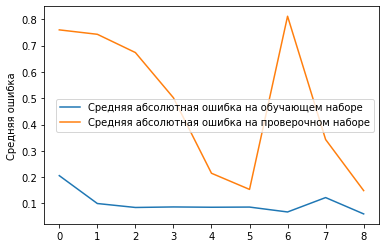

In [157]:
callback = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(32, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(32, return_sequences="True"))
model.add(Conv1D(64, 3, activation="linear"))
model.add(Conv1D(64, 3, activation="linear"))
model.add(Flatten())
model.add(Dense(3, activation="linear"))
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [158]:
pred = model.predict(dataset_train).flatten()
pred_val = model.predict(dataset_val).flatten()

In [164]:
print(pred.shape)
print(y_train.shape)

(2345,)
(2349,)


In [165]:
r2_score(y_true=y_test[xLen:], y_pred=pred_val[:-1])

0.9168842444179279

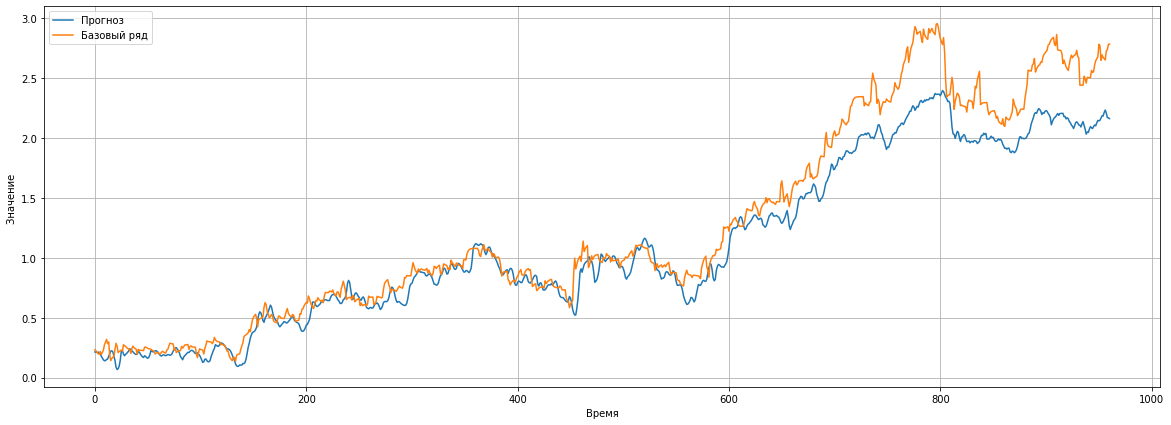

In [173]:
plt.figure(figsize=(20,7))
plt.grid('on')
plt.plot(pred_val[:-1], label='Прогноз')
plt.plot(y_test[xLen:], label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

In [170]:
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

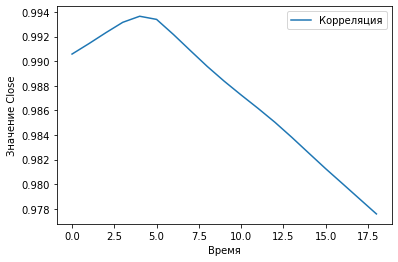

In [179]:
corr = []

for i in range(1,20):
  corr.append(correlate(y_test[xLen:-i], pred_val[i:-1]))
  
plt.plot(corr, label='Корреляция')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

Запаздывание в 4-5 дней. 
Его и на графике видно


In [188]:
def trin_func(layers=list(), batch_size=32, epochs=10, optimizer='adam', LSTMunit=32):
    dataset_train = keras.preprocessing.timeseries_dataset_from_array(
        X_train,
        y_train,
        sequence_length=xLen,
        sampling_rate=1,
        batch_size=batch_size,
    )
    dataset_val = keras.preprocessing.timeseries_dataset_from_array(
        X_test,
        y_test,
        sequence_length=xLen,
        sampling_rate=1,
        batch_size=batch_size,
    )

    callback = EarlyStopping(monitor='val_mae', patience=5)

    for batch in dataset_train.take(2):
        inputs, targets = batch

    print('Структура модели')
    model = Sequential()

    model.add(LSTM(LSTMunit, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
    for layer in layers:
        model.add(layer)

    model.summary()

    model.compile(loss="mse", optimizer=optimizer, metrics=['mae'])

    history = model.fit(
        dataset_train,
        epochs=epochs,
        validation_data=dataset_val,
        callbacks=[callback],
        verbose=0)


    plt.plot(history.history['mae'][1:], 
            label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(history.history['val_mae'][1:], 
            label='Средняя абсолютная ошибка на проверочном наборе')
    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

    pred = model.predict(dataset_train).flatten()
    pred_val = model.predict(dataset_val).flatten()

    plt.figure(figsize=(20,7))
    plt.grid('on')
    plt.plot(pred_val[:-1], label='Прогноз')
    plt.plot(y_test[xLen:], label='Базовый ряд')
    plt.xlabel('Время')
    plt.ylabel('Значение ')

    plt.legend()
    plt.show()

    corr = []

    for i in range(1,20):
      corr.append(correlate(y_test[xLen:-i], pred_val[i:-1]))
      
    plt.plot(corr, label='Корреляция')
    plt.xlabel('Время')
    plt.ylabel('Значение Close')
    plt.legend()
    plt.show()

Структура модели
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 5, 64)             18688     
_________________________________________________________________
lstm_14 (LSTM)               (None, 5, 64)             33024     
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 3, 64)             12352     
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 1, 64)             12352     
_________________________________________________________________
flatten_7 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 195       
_________________________________________________________________
dense_15 (Dense)             (None, 1

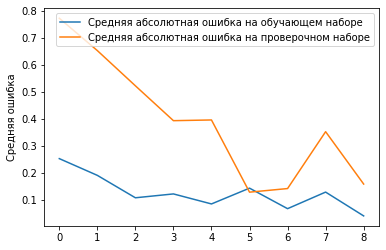

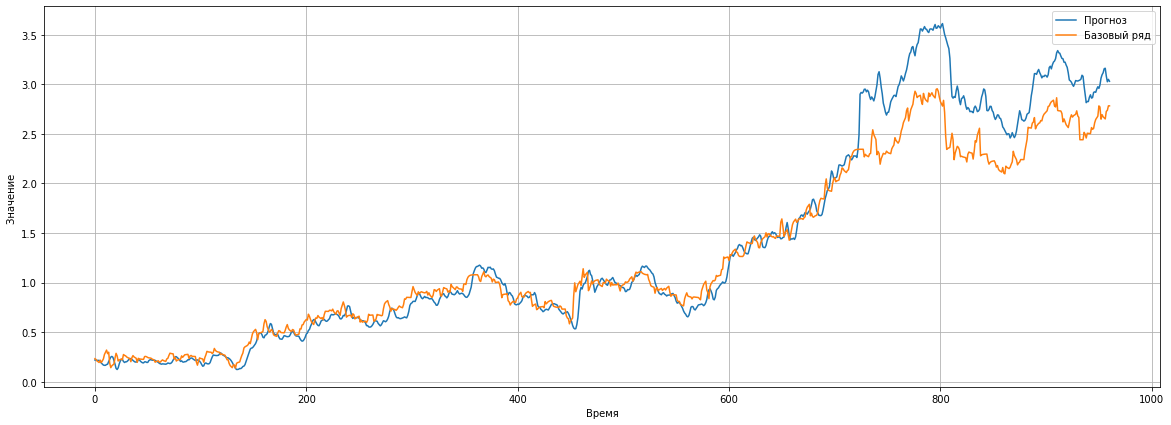

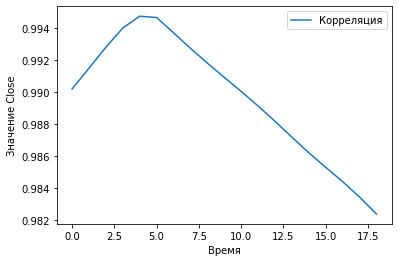

In [189]:
layers=list()

layers.append(LSTM(64, return_sequences="True"))
layers.append(Conv1D(64, 3, activation="linear"))
layers.append(Conv1D(64, 3, activation="linear"))
layers.append(Flatten())
layers.append(Dense(3, activation="linear"))
layers.append(Dense(1, activation="linear"))

optimazer = 'adam'

trin_func(layers=layers, batch_size=32, epochs=10, optimizer=optimazer, LSTMunit=64)

Вновь явное запаздывание

Структура модели
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 5, 64)             18688     
_________________________________________________________________
lstm_18 (LSTM)               (None, 5, 64)             33024     
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 3, 64)             12352     
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 1, 64)             12352     
_________________________________________________________________
flatten_9 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 195       
_________________________________________________________________
dense_19 (Dense)             (None, 1

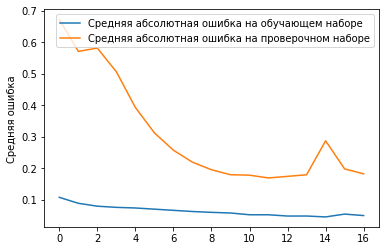

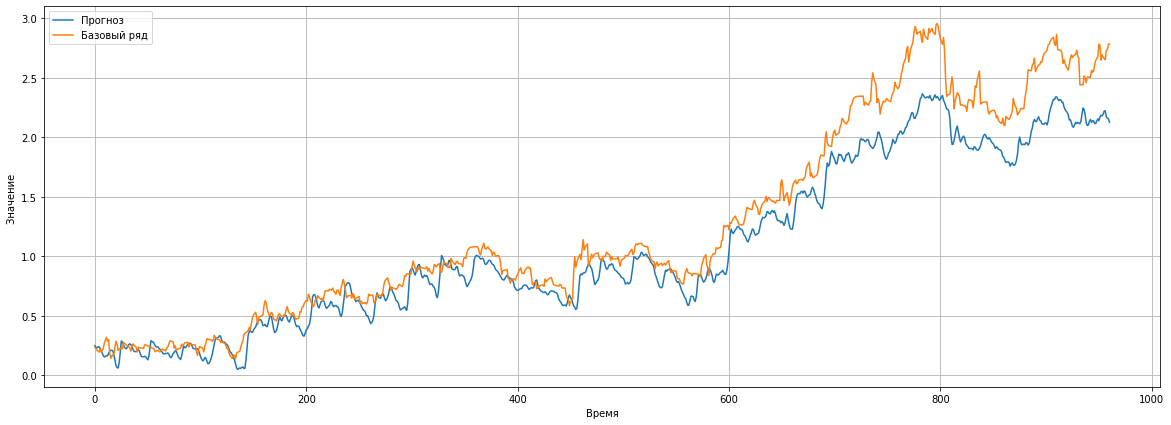

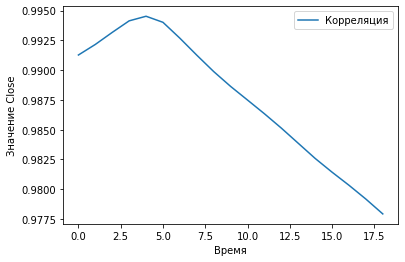

In [191]:
layers=list()

layers.append(LSTM(64, return_sequences="True"))
layers.append(Conv1D(64, 3, activation="linear"))
layers.append(Conv1D(64, 3, activation="linear"))
layers.append(Flatten())
layers.append(Dense(3, activation="linear"))
layers.append(Dense(1, activation="linear"))

optimazer = 'rmsprop'

trin_func(layers=layers, batch_size=32, epochs=30, optimizer=optimazer, LSTMunit=64)

С оптимизатором rmsprop пришлось увеличить batch_size, иначе не успевал

Структура модели
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 5, 64)             18688     
_________________________________________________________________
lstm_20 (LSTM)               (None, 5, 64)             33024     
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 3, 64)             12352     
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 1, 64)             12352     
_________________________________________________________________
flatten_10 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 195       
_________________________________________________________________
dense_21 (Dense)             (None, 

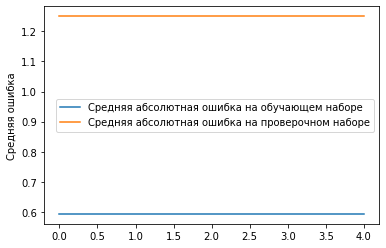

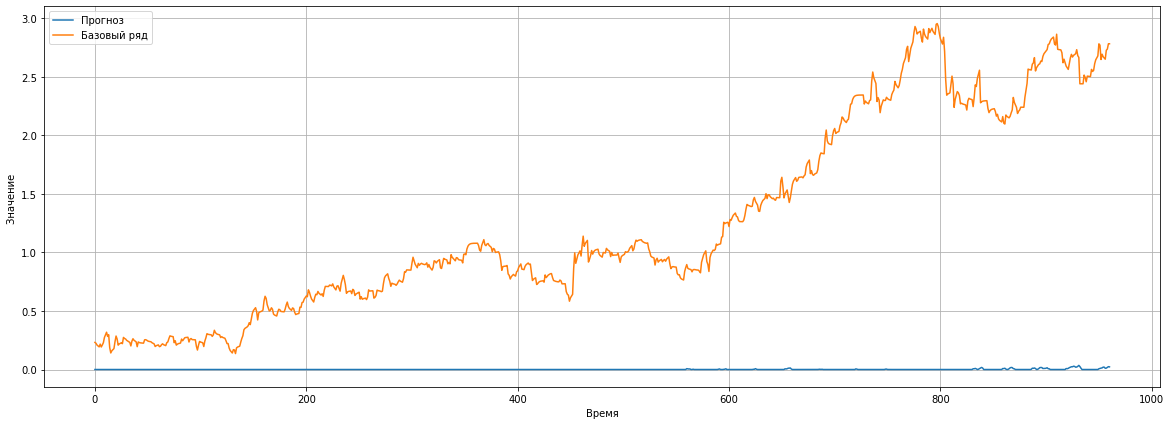

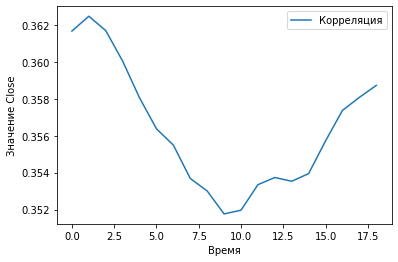

In [192]:
layers=list()

layers.append(LSTM(64, return_sequences="True"))
layers.append(Conv1D(64, 3, activation="relu"))
layers.append(Conv1D(64, 3, activation="relu"))
layers.append(Flatten())
layers.append(Dense(3, activation="relu"))
layers.append(Dense(1, activation="relu"))

optimazer = 'rmsprop'

trin_func(layers=layers, batch_size=32, epochs=30, optimizer=optimazer, LSTMunit=64)

Релу все сломала :)

Структура модели
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 5, 64)             18688     
_________________________________________________________________
lstm_22 (LSTM)               (None, 5, 64)             33024     
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 3, 64)             12352     
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 1, 64)             12352     
_________________________________________________________________
flatten_11 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 3)                 195       
_________________________________________________________________
dense_23 (Dense)             (None, 

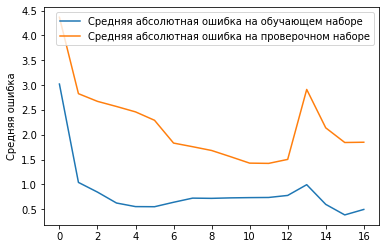

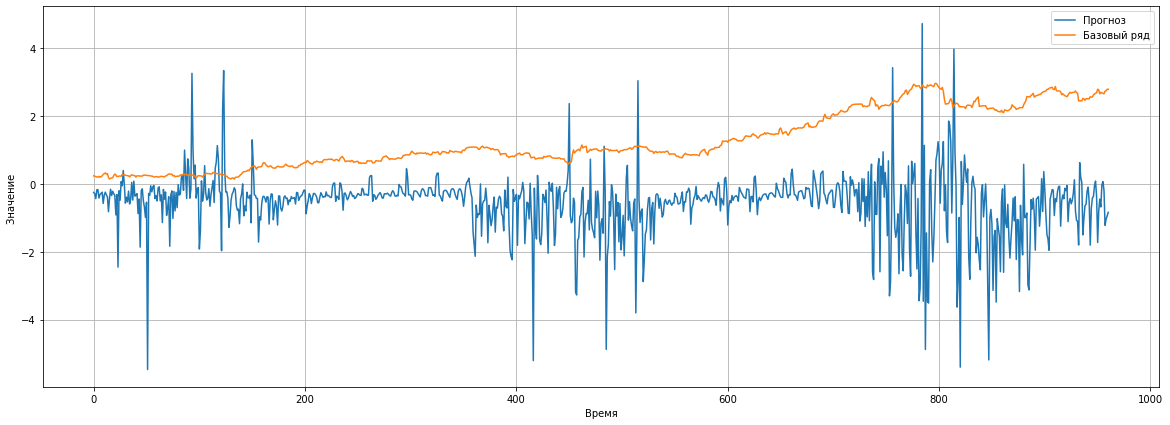

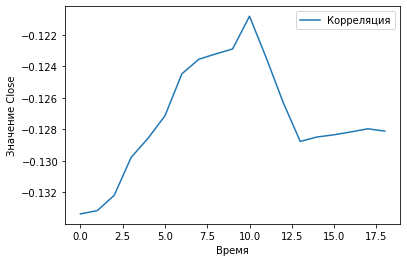

In [193]:
layers=list()

layers.append(LSTM(64, return_sequences="True"))
layers.append(Conv1D(64, 3, activation="linear"))
layers.append(Conv1D(64, 3, activation="linear"))
layers.append(Flatten())
layers.append(Dense(3, activation="linear"))
layers.append(Dense(1, activation="linear"))

optimazer = keras.optimizers.Adam(learning_rate=0.1)

trin_func(layers=layers, batch_size=32, epochs=30, optimizer=optimazer, LSTMunit=64)

Очевидно шаг слишком большой

Структура модели
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 5, 64)             18688     
_________________________________________________________________
lstm_24 (LSTM)               (None, 5, 64)             33024     
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 3, 64)             12352     
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 1, 64)             12352     
_________________________________________________________________
flatten_12 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 195       
_________________________________________________________________
dense_25 (Dense)             (None, 

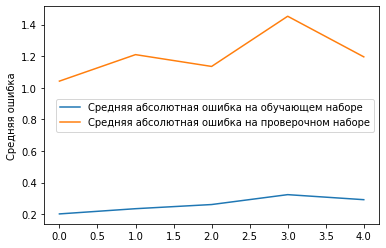

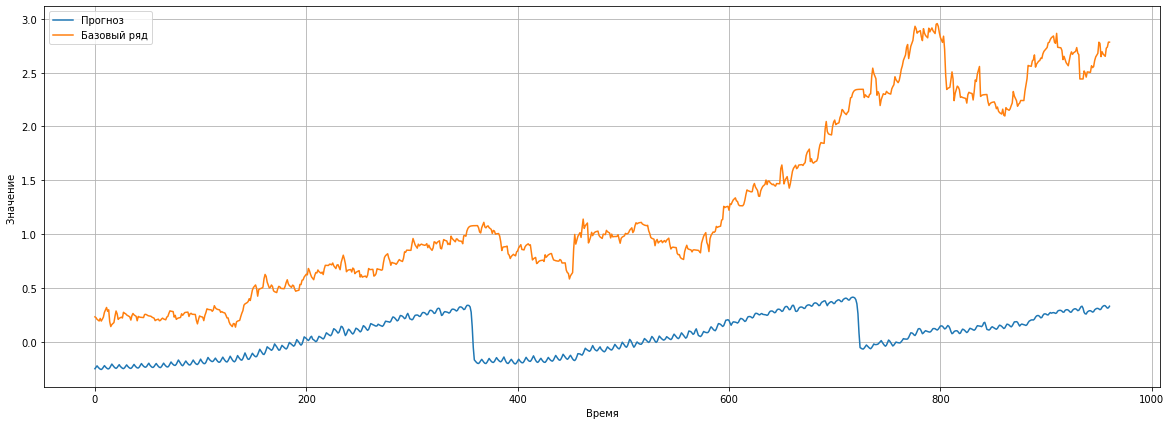

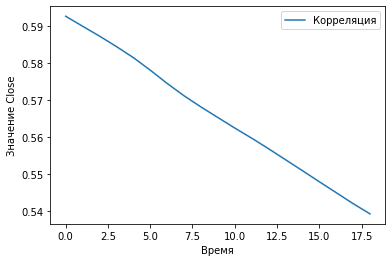

In [194]:
layers=list()

layers.append(LSTM(64, return_sequences="True"))
layers.append(Conv1D(64, 3, activation="linear"))
layers.append(Conv1D(64, 3, activation="linear"))
layers.append(Flatten())
layers.append(Dense(3, activation="linear"))
layers.append(Dense(1, activation="linear"))

optimazer = keras.optimizers.Adam(learning_rate=0.01)

trin_func(layers=layers, batch_size=32, epochs=30, optimizer=optimazer, LSTMunit=64)

Структура модели
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 5, 64)             18688     
_________________________________________________________________
lstm_26 (LSTM)               (None, 5, 64)             33024     
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 3, 64)             12352     
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 1, 64)             12352     
_________________________________________________________________
flatten_13 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 195       
_________________________________________________________________
dense_27 (Dense)             (None, 

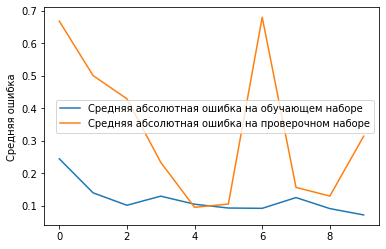

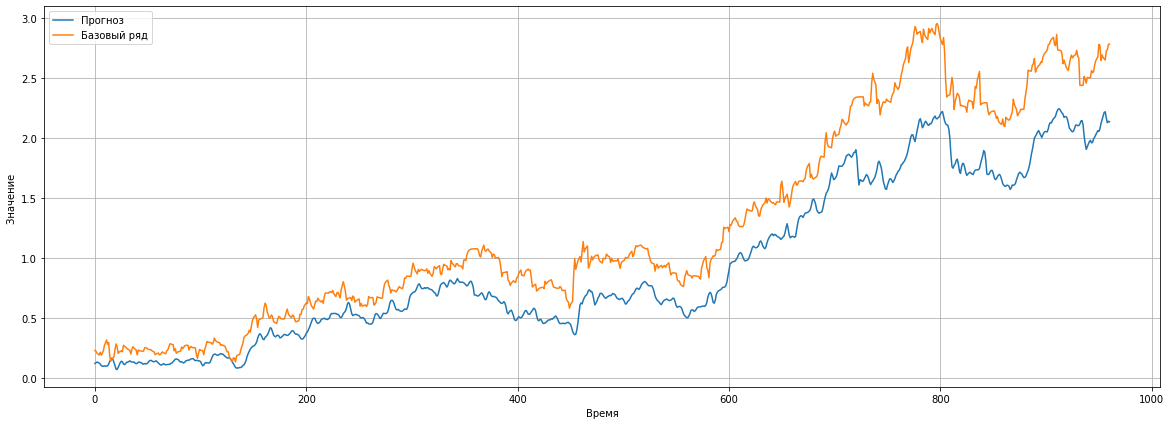

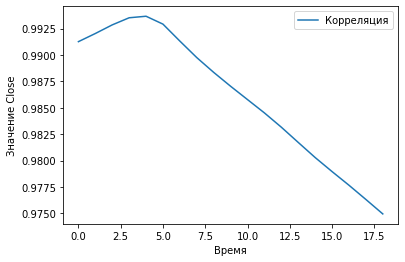

In [195]:
layers=list()

layers.append(LSTM(64, return_sequences="True"))
layers.append(Conv1D(64, 3, activation="linear"))
layers.append(Conv1D(64, 3, activation="linear"))
layers.append(Flatten())
layers.append(Dense(3, activation="linear"))
layers.append(Dense(1, activation="linear"))

optimazer = keras.optimizers.Adam(learning_rate=0.001)

trin_func(layers=layers, batch_size=32, epochs=30, optimizer=optimazer, LSTMunit=64)

Она опять обучилась, но это опять стабильное запаздывание

Структура модели
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 5, 32)             5248      
_________________________________________________________________
lstm_30 (LSTM)               (None, 5, 32)             8320      
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 3, 32)             3104      
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 1, 32)             3104      
_________________________________________________________________
flatten_15 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 3)                 99        
_________________________________________________________________
dense_31 (Dense)             (None, 

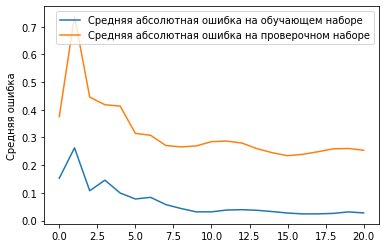

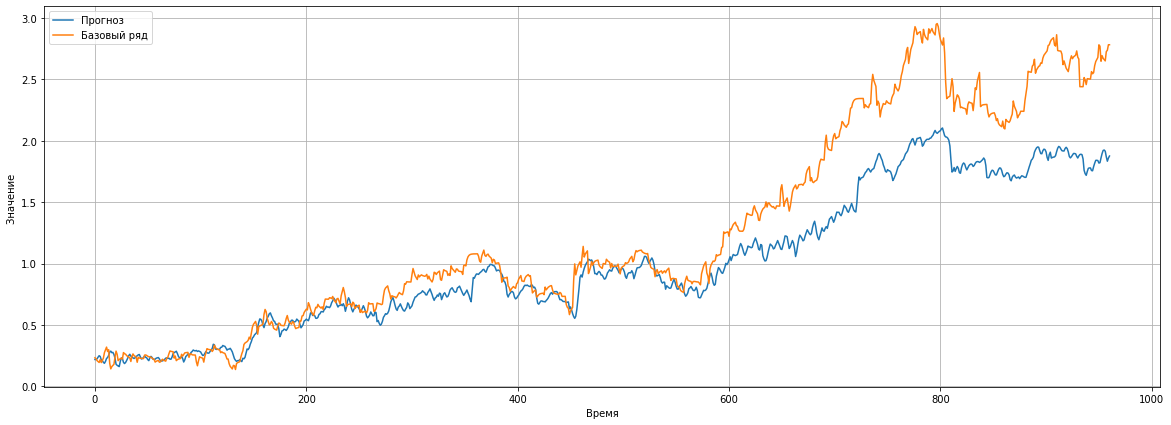

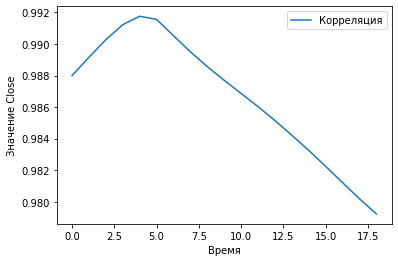

In [197]:
layers=list()

layers.append(LSTM(32, return_sequences="True"))
layers.append(Conv1D(32, 3, activation="linear"))
layers.append(Conv1D(32, 3, activation="linear"))
layers.append(Flatten())
layers.append(Dense(3, activation="linear"))
layers.append(Dense(1, activation="linear"))

optimazer = 'adam'

trin_func(layers=layers, batch_size=100, epochs=30, optimizer=optimazer, LSTMunit=32)

Структура модели
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 5, 128)            70144     
_________________________________________________________________
lstm_32 (LSTM)               (None, 5, 128)            131584    
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 3, 64)             24640     
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 1, 64)             12352     
_________________________________________________________________
flatten_16 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 3)                 195       
_________________________________________________________________
dense_33 (Dense)             (None, 

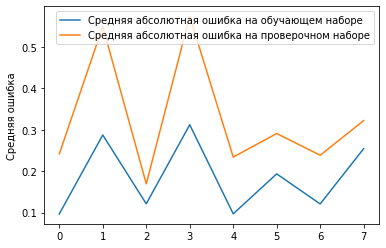

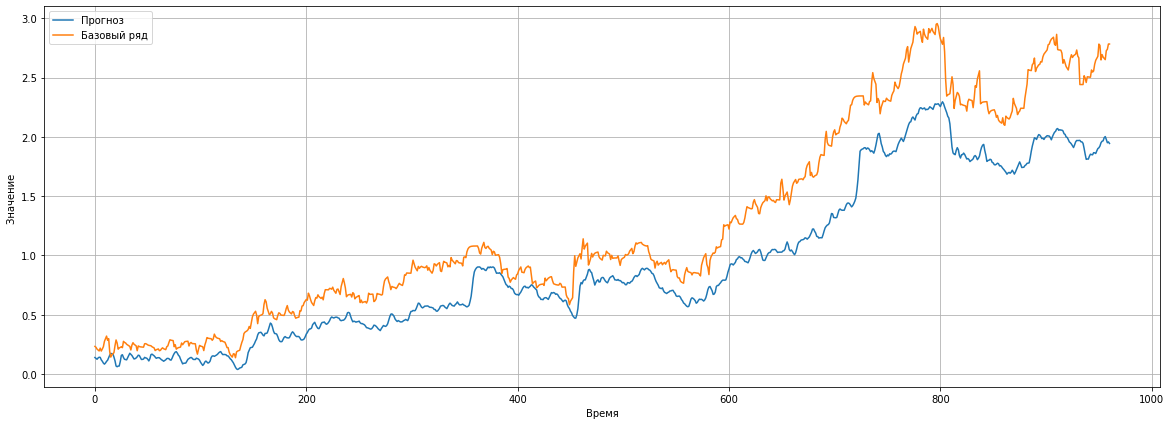

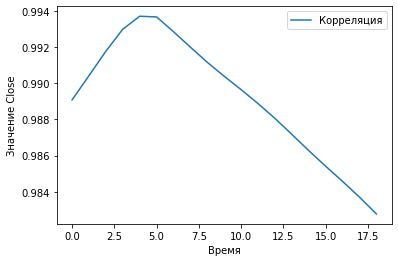

In [198]:
layers=list()

layers.append(LSTM(128, return_sequences="True"))
layers.append(Conv1D(64, 3, activation="linear"))
layers.append(Conv1D(64, 3, activation="linear"))
layers.append(Flatten())
layers.append(Dense(3, activation="linear"))
layers.append(Dense(1, activation="linear"))

optimazer = 'adam'

trin_func(layers=layers, batch_size=100, epochs=30, optimizer=optimazer, LSTMunit=128)

Не получил ниодной работоспособной модели. К то муже LSTM Совершенно не ловит тренды. По графикам видно, что данные увеличиваются, а модель не может это учесть и упирается в верхний предел. Но хотя это логично, модель же не видела, что данные могут принимать такие большие значения. Потому на всех графиках с время 600 и выше можна не учитывать.

Однако это не отменяет того факта, что я стабильно получаю 5 дневное запаздывание.

Возможно нужно начать с начала добавить дополнительные параметры, типа разницы между текущим и предыдущим днем итд..

+Думаю нужно увеличивать кол-во нейронов в слоях нейронной сети сети LSTМ, но могут возникнуть серьезные проблемы с обучением такой неустойчивой структуры, особенно на наших ограниченных мощностях.

*Попробуйте на numpy реализовать нейронную сеть архитектуры LSTM

Нашел реализацию LSTM на numpy http://blog.varunajayasiri.com/numpy_lstm.html. Такое мне не меньше недели писать, не отвлекаясь на работу.

*Предложите свои варианты решения проблемы исчезающего градиента в RNN

1. Укоротить сеть. Чем короче сеть тем меньше затухает
2. Добавить прямую связь входа с выходом, как это сделано в LSTm.